<a href="https://colab.research.google.com/github/NamanJhawar-NMIMS/Classification-with-pyspark/blob/main/Assignment_Classification_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Table of Contents**

>[Table of Contents](#scrollTo=EuMFH5U2Y3W4)

>[Import](#scrollTo=Znx-l3msYrFJ)

>[Create the pyspark Session](#scrollTo=MhhRFXx4Y86g)

>>[Loading the Dataset](#scrollTo=peyWMxNLY_09)

>[Preprocessing](#scrollTo=ky2jG1DSZLwk)

>>[Drop unwanted columns from the dataset](#scrollTo=2BioBda0ZFcP)

>>[Shape of Data](#scrollTo=i0iA5wNiZQh-)

>>[Data Schema](#scrollTo=A78MlvxmZWQQ)

>>[Data description](#scrollTo=Yse6oD9hZTvW)

>[Preprocessing with pyspark.ml.features](#scrollTo=FOo5zqO4ZeRQ)

>>[Imputer](#scrollTo=0ZyfTplLdD6F)

>>[StringIndexer](#scrollTo=Co_GgkrZ9APQ)

>>>[Pipeline](#scrollTo=J3UAYHXYEEWN)

>>[SQLTransformer](#scrollTo=jvx_W7gVB4Qu)

>>>[Graph: Age distribution](#scrollTo=T6zg6wvYZpXx)

>>[Binarizer](#scrollTo=JyWXlbaPESpO)

>>[Bucketizer](#scrollTo=G_94DEUuLB-s)

>>>[Graph: Monthly income buckets and Average Monthly Salary](#scrollTo=sjV3KyTTZu4Q)

>>[QuantileDiscretizer](#scrollTo=rrIJYmW84olE)

>>[RegexTokenizer](#scrollTo=ZDhdyP27L-kJ)

>>[One hot encoder](#scrollTo=-UTmSbz-LFWJ)

>>>[Dropping Unwanted Columns post preprocessing](#scrollTo=JmrJ3HELgLky)

>>[VectorAssembler](#scrollTo=NTrE39Ax3G-J)

>>[StandardScalar](#scrollTo=6J7Uz21Xveq5)

>[Classification](#scrollTo=WmkTdOx0Aj7j)

>>[Train test Split](#scrollTo=Sm93VqETaTz9)

>>[Logistic Regression](#scrollTo=zjYx6KTKA1k8)

>>[LinearSVC](#scrollTo=JGu_xv2eAmN2)

>>[DecisionTreeClassifier](#scrollTo=_YoPUemsA6iy)

>>[GBTClassifier](#scrollTo=p4oOYChYBEE1)

>>[RandomForestClassifier](#scrollTo=w6JBqvmDBHl6)

>>[Model Evaluation](#scrollTo=avtLxBLMa2Sl)

>>>[Create a dataframe of all the models and their metrics](#scrollTo=ULuYPjkqYS3h)

>>>[Best Model](#scrollTo=uEA9B8t1YZxb)

>>[Inference](#scrollTo=gmYXm5mpa5v-)



# Import

Import all the necessary libraries 

In [1]:
try:
  from pyspark.sql import SparkSession
except:
  !pip install pyspark
  !pip install wget
  
from pyspark.sql import SparkSession
import wget
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.types import IntegerType,BooleanType,DateType

from pyspark.ml.feature import Imputer, StringIndexer,SQLTransformer,Binarizer,RegexTokenizer
from pyspark.ml.feature import OneHotEncoder,StandardScaler,Bucketizer,QuantileDiscretizer, VectorAssembler
from pyspark.ml.pipeline import Pipeline

%matplotlib inline

# Create the pyspark Session

In [2]:
session=SparkSession.builder.appName("Classification").master("local").getOrCreate()

## Loading the Dataset

In [3]:
dataset=session.read.csv(wget.download("https://raw.githubusercontent.com/NamanJhawar-NMIMS/Classification-with-pyspark/main/watson_healthcare_attrition.csv"),header=True,inferSchema=True)

In [4]:
dataset.show(5)

+----------+---+---------+-----------------+---------+----------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|EmployeeID|Age|Attrition|   BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|Shift|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrMan

# Preprocessing

In [5]:
original_columns=list(dataset.columns)

## Drop unwanted columns from the dataset

In [6]:
# Dropping these columns as they are not important and won't help in the classification
dataset=dataset.drop(*['StandardHours','EmployeeID','EmployeeCount','Over18'])


In [7]:
dataset.show(5)

+---+---------+-----------------+---------+----------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|Shift|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+-----------------+---------+----------+----------------+---------+-----

In [8]:
dataset.count()

1676

## Shape of Data

In [9]:
print(f"Shape of Data:\n{dataset.count(),len(dataset.columns)}")

Shape of Data:
(1676, 31)


## Data Schema

In [10]:
dataset.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- Relations

## Data description

In [11]:
dataset.describe().show()

+-------+-----------------+---------+--------------+-----------------+----------+----------------+------------------+----------------+-----------------------+------+-----------------+------------------+------------------+---------+------------------+-------------+-----------------+-----------------+------------------+--------+------------------+------------------+------------------------+------------------+-----------------+---------------------+------------------+-----------------+------------------+-----------------------+--------------------+
|summary|              Age|Attrition|BusinessTravel|        DailyRate|Department|DistanceFromHome|         Education|  EducationField|EnvironmentSatisfaction|Gender|       HourlyRate|    JobInvolvement|          JobLevel|  JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|      MonthlyRate|NumCompaniesWorked|OverTime| PercentSalaryHike| PerformanceRating|RelationshipSatisfaction|             Shift|TotalWorkingYears|TrainingTimesLastYea

In [12]:
print(f"Number of columns: {len(dataset.columns)}")

Number of columns: 31


In [13]:
df_dataset=pd.read_csv('watson_healthcare_attrition.csv')


In [14]:
df_temp=(df_dataset.isnull().sum()).to_frame()
df_temp[df_temp[0]>0]
columns_with_missing_values=list(df_temp[df_temp[0]>0].index)

In [15]:
dataset[columns_with_missing_values].printSchema()

# There are 3 integer variables with missing values
# There are 1 string variables with missing values

root
 |-- Age: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)



In [16]:
dataset.columns

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'Shift',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

# Preprocessing with pyspark.ml.features

## 1. Imputer

In [17]:
imputer = Imputer()
imputer.setInputCols(list(set(columns_with_missing_values)-set(['MaritalStatus'])))
imputer.setOutputCols([outcol+"_imputed" for outcol in list(set(columns_with_missing_values)-set(['MaritalStatus']))])
imputer.setStrategy("median")


Imputer_7728f8548cba

##2. StringIndexer
Impute Categorical Variables

This can be achived by first label encoding the categorical column and then using imputation.

In [18]:
stringIndexer_imputer=StringIndexer(inputCol='MaritalStatus',outputCol='MaritalStatus_indexed',stringOrderType="frequencyDesc",handleInvalid='keep')


### Pipeline

In [19]:
mypipeline_imputer=Pipeline(stages=[imputer,stringIndexer_imputer])
dataset=mypipeline_imputer.fit(dataset).transform(dataset)


In [20]:

"""As the MaritalStatus_Indexed column has null values and we have handled the Invalid cells, we need to remove that category which has
been created by the system to handle null values. In order to do that, we will convert the pyspark Dataframe into a pandas Dataframe and 
then replace the last category with null values"""

pd_df=dataset.toPandas()
pd_df.loc[pd_df[pd_df.MaritalStatus_indexed==3].index,"MaritalStatus_indexed"]=np.nan
dataset=session.createDataFrame(pd_df)

imputer_category=Imputer(inputCol="MaritalStatus_indexed",outputCol='MaritalStatus_indexed_imputed',strategy="mode")

mypipeline=Pipeline(stages=[imputer_category])
dataset=mypipeline.fit(dataset).transform(dataset)

# drop the columns that are not needed

dataset=dataset.drop("MaritalStatus_indexed")
dataset.show()

+----+---------+-----------------+---------+----------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+--------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----------------------------+-----------+-----------------+-----------------------------+
| Age|Attrition|   BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|       JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|Shift|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|Ye

## 3. SQLTransformer

In [21]:
sqlTrans = SQLTransformer(statement="select Age, count(Age) from  __THIS__ group by Age order by age desc")
sql_age=sqlTrans.transform(dataset)
sql_age.show()

+----+----------+
| Age|count(Age)|
+----+----------+
| NaN|        12|
|60.0|         5|
|59.0|        10|
|58.0|        17|
|56.0|        15|
|55.0|        25|
|54.0|        20|
|53.0|        25|
|52.0|        21|
|51.0|        20|
|50.0|        33|
|49.0|        29|
|48.0|        23|
|47.0|        28|
|46.0|        38|
|45.0|        45|
|44.0|        36|
|43.0|        37|
|42.0|        52|
|41.0|        43|
+----+----------+
only showing top 20 rows



In [22]:
sql_age=sql_age.toPandas().dropna()

### Graph: Age distribution 

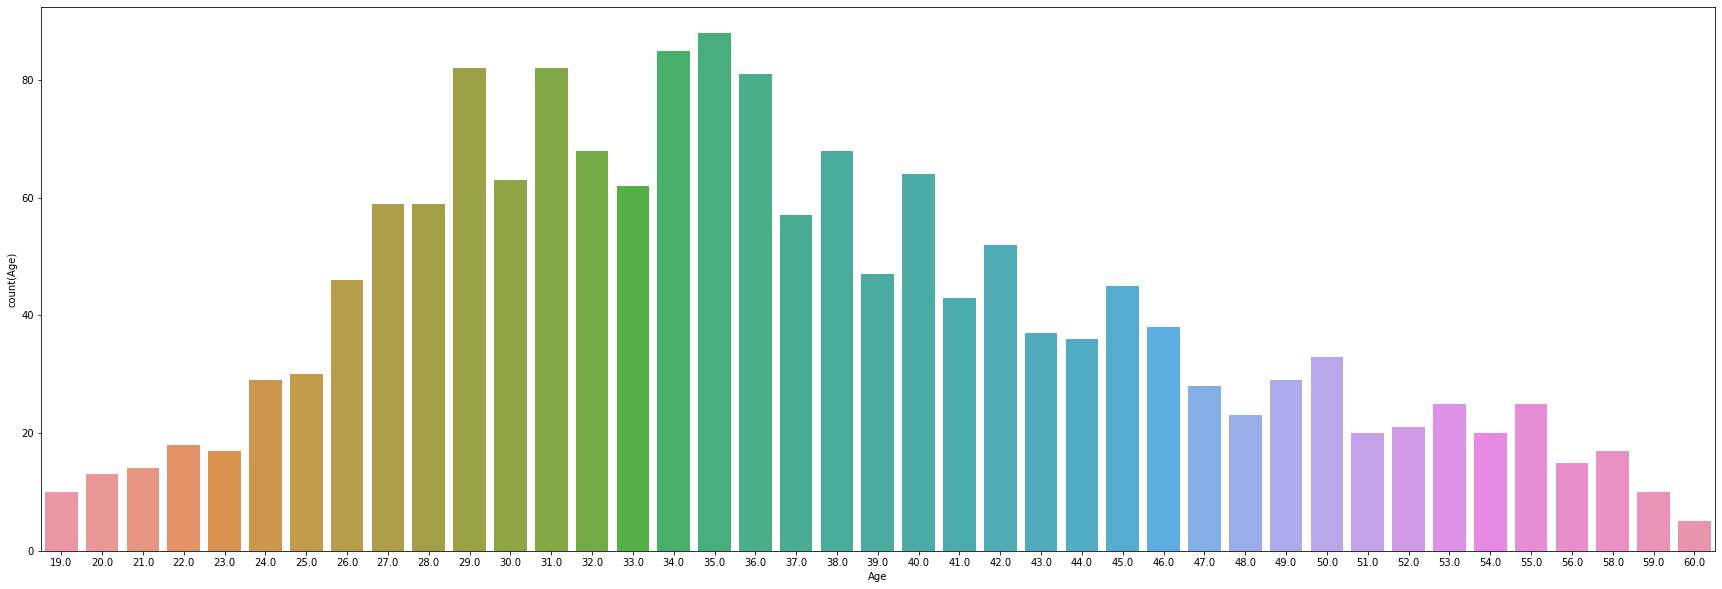

In [23]:
plt.figure(figsize=(30,10))
sns.barplot(x=sql_age.Age,y=sql_age['count(Age)']);

## 4. Binarizer

If the person has not been promoted in the last 3 years, then the value should be true (1) else false(0)

In [24]:
dataset=dataset.withColumn("YearsSinceLastPromotion",dataset.YearsSinceLastPromotion.cast("double"))

In [25]:
binarizer = Binarizer(threshold=3.0, inputCol="YearsSinceLastPromotion", outputCol="YearsSinceLastPromotionGt3")
dataset=binarizer.transform(dataset)

In [26]:
dataset.select('YearsSinceLastPromotion','YearsSinceLastPromotiongt3').show(10)

+-----------------------+--------------------------+
|YearsSinceLastPromotion|YearsSinceLastPromotiongt3|
+-----------------------+--------------------------+
|                    0.0|                       0.0|
|                    1.0|                       0.0|
|                    0.0|                       0.0|
|                    3.0|                       0.0|
|                    2.0|                       0.0|
|                    3.0|                       0.0|
|                    0.0|                       0.0|
|                    0.0|                       0.0|
|                    1.0|                       0.0|
|                    7.0|                       1.0|
+-----------------------+--------------------------+
only showing top 10 rows



## 5. Bucketizer

In [27]:
bucketizer = Bucketizer(splits=[-float("inf"), 2926.75, 4899,8380.75, float("inf")],inputCol="MonthlyIncome", outputCol="MonthlyIncome_buckets")
dataset=bucketizer.transform(dataset)

In [28]:
dataset.select("MonthlyIncome",'MonthlyIncome_buckets').groupBy('MonthlyIncome_buckets').sum().orderBy('sum(MonthlyIncome)').show()

+---------------------+------------------+--------------------------+
|MonthlyIncome_buckets|sum(MonthlyIncome)|sum(MonthlyIncome_buckets)|
+---------------------+------------------+--------------------------+
|                  0.0|            986805|                       0.0|
|                  1.0|           1660574|                     419.0|
|                  2.0|           2588943|                     838.0|
|                  3.0|           5685353|                    1257.0|
+---------------------+------------------+--------------------------+



### Graph: Monthly income buckets and Average Monthly Salary

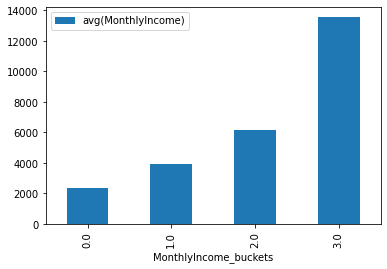

In [29]:
dataset.select("MonthlyIncome",'MonthlyIncome_buckets').groupBy('MonthlyIncome_buckets').avg().orderBy('avg(MonthlyIncome)').toPandas().plot.bar(x='MonthlyIncome_buckets',y='avg(MonthlyIncome)');

## 6. QuantileDiscretizer 

In [30]:
quant_obj=QuantileDiscretizer(numBuckets=4, inputCol="DailyRate_imputed", outputCol="DailyRate_imputed"+"_quant", relativeError=0.001)
dataset=quant_obj.fit(dataset).transform(dataset)
dataset.select("DailyRate_imputed_quant","DailyRate_imputed").orderBy("DailyRate_imputed_quant").show()

+-----------------------+-----------------+
|DailyRate_imputed_quant|DailyRate_imputed|
+-----------------------+-----------------+
|                    0.0|              240|
|                    0.0|              313|
|                    0.0|              142|
|                    0.0|              279|
|                    0.0|              394|
|                    0.0|              153|
|                    0.0|              441|
|                    0.0|              334|
|                    0.0|              249|
|                    0.0|              391|
|                    0.0|              147|
|                    0.0|              464|
|                    0.0|              216|
|                    0.0|              427|
|                    0.0|              364|
|                    0.0|              132|
|                    0.0|              438|
|                    0.0|              397|
|                    0.0|              201|
|                    0.0|       

## 7. RegexTokenizer

In [31]:
regTokenize=RegexTokenizer(inputCol="DistanceFromHome",outputCol="DistanceFromHome_reg",pattern=" km")
dataset=regTokenize.transform(dataset)

# The regTokenizer returns a column with the datatype as Array, which contains the value in string format. We need to first extract the value from the Array and then typecast it into Interger.
dataset=dataset.withColumn("DistanceFromHome_reg",dataset.DistanceFromHome_reg[0])
dataset=dataset.withColumn("DistanceFromHome_reg",dataset.DistanceFromHome_reg.cast("int"))

dataset.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: double (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: long (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: long (nullable = true)
 |-- JobInvolvement: long (nullable = true)
 |-- JobLevel: long (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: long (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: long (nullable = true)
 |-- MonthlyRate: long (nullable = true)
 |-- NumCompaniesWorked: long (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike: long (nullable = true)
 |-- PerformanceRating: long (nullable = true)
 |-- RelationshipSatisfaction: long (nullable = t

## 8. One hot encoder


In [32]:
""" 
In order to one hot encode all the categorical variables, we need to do the following steps
 1. Identify all the categorical Variables
 2. Check if they have any inherent Hierachy
 3. Apply StringIndexer to all the categorical variables
 4. OneHotEncode only those categorical variables that do not have any hierachy
"""
def return_col_basedOnType(dataType):
  cat_col=[]
  for col,data_type in dataset.dtypes:
    if data_type==dataType:
      cat_col.append(col)

  print(cat_col)
  return cat_col

cat_col=return_col_basedOnType("string")
"""
 Out of the above columns, MaritalStatus has already been StringIndexed and now only needs to be One hot encoded.
 DistanceFromHome Column is not needed as we have already preprocessed it and converted it into a int column
 Attrition is the Dependent variable and hence will not be one hot encoded
 None of the other variables have a hierarchy and hence we are okay to onehotencode them
"""
cat_col.pop(cat_col.index('DistanceFromHome'))
cat_col.pop(cat_col.index('MaritalStatus'))
# Drop Over18 as this column has only 1 category and as such is not useful

bulk_indexer=StringIndexer(inputCols=cat_col,outputCols=[x+"_indexed" for x in cat_col])

# Before one hot encode, make sure to drop the dependent variable and add the other Categorical variable
inputColumns=list(set(bulk_indexer.getOutputCols())-set(['Attrition','Attrition_indexed']))
inputColumns.extend(['MaritalStatus_indexed_imputed', 'YearsSinceLastPromotionGt3', 'MonthlyIncome_buckets'])
oneHotEncoder=OneHotEncoder(inputCols=inputColumns,outputCols=[x+"_onehot" for x in inputColumns])
print(inputColumns)

myPipeline_bulk=Pipeline(stages=[bulk_indexer,oneHotEncoder])
dataset=myPipeline_bulk.fit(dataset).transform(dataset)
dataset.show()

['Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
['EducationField_indexed', 'JobRole_indexed', 'Gender_indexed', 'BusinessTravel_indexed', 'OverTime_indexed', 'Department_indexed', 'MaritalStatus_indexed_imputed', 'YearsSinceLastPromotionGt3', 'MonthlyIncome_buckets']
+----+---------+-----------------+---------+----------+----------------+---------+--------------+-----------------------+------+----------+--------------+--------+--------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+-----+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----------------------------+-----------+-----------------+-----------------------------+--------------------------+---------------------+-----------------------+-------------------

### Dropping Unwanted Columns post preprocessing

In [33]:
def dataset_shape(dataset):
  print("The shape of dataset",(dataset.count(),len(dataset.columns)))


In [34]:
print(f"Dropping the following Columns:\n{inputColumns}")
print(dataset.count(),len(dataset.columns))
dataset=dataset.drop(*inputColumns)
print(dataset.count(),len(dataset.columns))

Dropping the following Columns:
['EducationField_indexed', 'JobRole_indexed', 'Gender_indexed', 'BusinessTravel_indexed', 'OverTime_indexed', 'Department_indexed', 'MaritalStatus_indexed_imputed', 'YearsSinceLastPromotionGt3', 'MonthlyIncome_buckets']
1676 55
1676 46


In [35]:
columnsToDropBasedOnPreprocessing=list(set(dataset.columns)-set(original_columns))
# Drop all the original columns from which we have either imputed/Indexed/OneHotEncoded from the above list
colDrop=[]
for col in columnsToDropBasedOnPreprocessing:
  x=col.split("_")
  if len(x)>2:
    for item in x[:-1]:
      if item=='indexed':
        if x[x.index(item)-1]+"_"+item=='Attrition_indexed': #Ignore if the column is Dependent variable
          pass
        else:
          colDrop.append(x[x.index(item)-1]+"_"+item)
      else:
        colDrop.append(item)
  else:
    colDrop.append(x[0])
dataset=dataset.drop(*colDrop)
dataset_shape(dataset)

The shape of dataset (1676, 33)


In [36]:
dataset.printSchema()

root
 |-- Education: long (nullable = true)
 |-- EnvironmentSatisfaction: long (nullable = true)
 |-- HourlyRate: long (nullable = true)
 |-- JobInvolvement: long (nullable = true)
 |-- JobLevel: long (nullable = true)
 |-- JobSatisfaction: long (nullable = true)
 |-- MonthlyRate: long (nullable = true)
 |-- NumCompaniesWorked: long (nullable = true)
 |-- PercentSalaryHike: long (nullable = true)
 |-- PerformanceRating: long (nullable = true)
 |-- RelationshipSatisfaction: long (nullable = true)
 |-- Shift: long (nullable = true)
 |-- TotalWorkingYears: long (nullable = true)
 |-- WorkLifeBalance: long (nullable = true)
 |-- YearsAtCompany: long (nullable = true)
 |-- YearsInCurrentRole: long (nullable = true)
 |-- YearsSinceLastPromotion: double (nullable = true)
 |-- YearsWithCurrManager: long (nullable = true)
 |-- TrainingTimesLastYear_imputed: long (nullable = true)
 |-- Age_imputed: long (nullable = true)
 |-- DailyRate_imputed: long (nullable = true)
 |-- DailyRate_imputed_quant

## 9. VectorAssembler

In [37]:
# Continious variables with different metric units need to undergo Standard Scaling so as to be correctly perceived by the model
"""
Steps:
1. Find all the continious variables
2. Check their scale
3. VectorAssemble all those columns as the input to StandardScaler is only 1 column
4. Run this processed column through standard scalar
"""
col_cont=['MonthlyRate','HourlyRate','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','DistanceFromHome_reg','DailyRate_imputed','Age_imputed','TrainingTimesLastYear_imputed','YearsWithCurrManager','YearsSinceLastPromotion','YearsInCurrentRole','YearsAtCompany']
vec_obj=VectorAssembler(inputCols=col_cont,outputCol="col_cont_allFeatures")

## 10. StandardScalar

In [38]:
standardScaler=StandardScaler(inputCol=vec_obj.getOutputCol(),outputCol=vec_obj.getOutputCol()+"_standardScaled")

myPipeline=Pipeline(stages=[vec_obj,standardScaler])
dataset=myPipeline.fit(dataset).transform(dataset)
dataset.show(truncate=False)

+---------+-----------------------+----------+--------------+--------+---------------+-----------+------------------+-----------------+-----------------+------------------------+-----+-----------------+---------------+--------------+------------------+-----------------------+--------------------+-----------------------------+-----------+-----------------+-----------------------+--------------------+-----------------+-----------------------------+----------------------+---------------------+-----------------------------+-----------------------+-------------------------+------------------------------------+---------------------------------+----------------------------+------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Education|

In [39]:
# Finally create a vector that would be passed to the Classification models
dataset_shape(dataset)
dataset.printSchema()

The shape of dataset (1676, 35)
root
 |-- Education: long (nullable = true)
 |-- EnvironmentSatisfaction: long (nullable = true)
 |-- HourlyRate: long (nullable = true)
 |-- JobInvolvement: long (nullable = true)
 |-- JobLevel: long (nullable = true)
 |-- JobSatisfaction: long (nullable = true)
 |-- MonthlyRate: long (nullable = true)
 |-- NumCompaniesWorked: long (nullable = true)
 |-- PercentSalaryHike: long (nullable = true)
 |-- PerformanceRating: long (nullable = true)
 |-- RelationshipSatisfaction: long (nullable = true)
 |-- Shift: long (nullable = true)
 |-- TotalWorkingYears: long (nullable = true)
 |-- WorkLifeBalance: long (nullable = true)
 |-- YearsAtCompany: long (nullable = true)
 |-- YearsInCurrentRole: long (nullable = true)
 |-- YearsSinceLastPromotion: double (nullable = true)
 |-- YearsWithCurrManager: long (nullable = true)
 |-- TrainingTimesLastYear_imputed: long (nullable = true)
 |-- Age_imputed: long (nullable = true)
 |-- DailyRate_imputed: long (nullable = tr

In [40]:
dataset=dataset.drop(*['col_cont_allFeatures'])
dataset=dataset.drop(*vec_obj.getInputCols())

In [41]:
dataset_shape(dataset)
dataset.printSchema()

The shape of dataset (1676, 21)
root
 |-- Education: long (nullable = true)
 |-- EnvironmentSatisfaction: long (nullable = true)
 |-- JobInvolvement: long (nullable = true)
 |-- JobLevel: long (nullable = true)
 |-- JobSatisfaction: long (nullable = true)
 |-- PerformanceRating: long (nullable = true)
 |-- RelationshipSatisfaction: long (nullable = true)
 |-- Shift: long (nullable = true)
 |-- WorkLifeBalance: long (nullable = true)
 |-- DailyRate_imputed_quant: double (nullable = true)
 |-- Attrition_indexed: double (nullable = false)
 |-- EducationField_indexed_onehot: vector (nullable = true)
 |-- JobRole_indexed_onehot: vector (nullable = true)
 |-- Gender_indexed_onehot: vector (nullable = true)
 |-- BusinessTravel_indexed_onehot: vector (nullable = true)
 |-- OverTime_indexed_onehot: vector (nullable = true)
 |-- Department_indexed_onehot: vector (nullable = true)
 |-- MaritalStatus_indexed_imputed_onehot: vector (nullable = true)
 |-- YearsSinceLastPromotionGt3_onehot: vector (n

In [42]:
final_vec_obj=VectorAssembler(inputCols=list(set(dataset.columns)-set('Attrition_indexed')),outputCol="final_features")
dataset=final_vec_obj.transform(dataset)
dataset.select(final_vec_obj.getOutputCol()).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Classification

In [43]:
from pyspark.ml.classification import LogisticRegression,LinearSVC,DecisionTreeClassifier,GBTClassifier,RandomForestClassifier,MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time

## Train test Split

In [44]:
train,test=dataset.randomSplit([0.8,0.2],seed=2000)


In [45]:
model_metric={}
runtimeOfModels=[]
def evaluation_function(dataset,rawPredictionCol="rawPrediction",labelCol="Attrition_indexed",metricName="areaUnderROC"):
  eval=BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol,labelCol=labelCol,metricName=metricName)
  result=eval.evaluate(dataset)
  print(f"The model has {eval.getMetricName()} value of {result}")
  return result

## 1. Logistic Regression

In [46]:
model_metric

{}

In [47]:
time1=time.time()

model=LogisticRegression(featuresCol=final_vec_obj.getOutputCol(),labelCol="Attrition_indexed")
logReg_results=model.fit(train).transform(test)
print(logReg_results.select(model.getFeaturesCol(),model.getLabelCol(),'rawPrediction','prediction').show())
model_metric[str(model).split("_")[0]]=evaluation_function(logReg_results)

runtimeOfModels.append(time.time()-time1)



+--------------------+-----------------+--------------------+----------+
|      final_features|Attrition_indexed|       rawPrediction|prediction|
+--------------------+-----------------+--------------------+----------+
|[3.0,1.0,1.0,3.0,...|              0.0|[17.9542598069551...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[18.0100241327488...|       0.0|
|[3.0,1.0,1.0,3.0,...|              1.0|[-19.220920921076...|       1.0|
|[3.0,0.0,4.0,3.0,...|              0.0|[19.6705000689218...|       0.0|
|(45,[0,1,2,3,7,8,...|              0.0|[18.7989799160618...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[18.4196348506828...|       0.0|
|(45,[0,2,3,5,7,8,...|              0.0|[18.4212149376522...|       0.0|
|(45,[0,1,2,3,5,7,...|              0.0|[18.5907379986196...|       0.0|
|[3.0,1.0,1.0,1.0,...|              1.0|[-20.251910058809...|       1.0|
|(45,[0,2,3,7,8,13...|              0.0|[18.5445819547094...|       0.0|
|[3.0,2.0,2.0,1.0,...|              0.0|[18.7659963

## 2. LinearSVC

In [48]:
time1=time.time()

model=LinearSVC(featuresCol=final_vec_obj.getOutputCol(),labelCol="Attrition_indexed")
linearSVC_results=model.fit(train).transform(test)
print(linearSVC_results.select(model.getFeaturesCol(),model.getLabelCol(),'rawPrediction','prediction').show())
model_metric[str(model).split("_")[0]]=evaluation_function(linearSVC_results)

runtimeOfModels.append(time.time()-time1)

+--------------------+-----------------+--------------------+----------+
|      final_features|Attrition_indexed|       rawPrediction|prediction|
+--------------------+-----------------+--------------------+----------+
|[3.0,1.0,1.0,3.0,...|              0.0|[1.37471181193747...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[1.45947498913917...|       0.0|
|[3.0,1.0,1.0,3.0,...|              1.0|[-2.3996302416525...|       1.0|
|[3.0,0.0,4.0,3.0,...|              0.0|[2.25573566446467...|       0.0|
|(45,[0,1,2,3,7,8,...|              0.0|[1.78800714605169...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[1.62406941029729...|       0.0|
|(45,[0,2,3,5,7,8,...|              0.0|[1.81682502110252...|       0.0|
|(45,[0,1,2,3,5,7,...|              0.0|[1.78104481930327...|       0.0|
|[3.0,1.0,1.0,1.0,...|              1.0|[-3.0538039559703...|       1.0|
|(45,[0,2,3,7,8,13...|              0.0|[1.77914769640668...|       0.0|
|[3.0,2.0,2.0,1.0,...|              0.0|[2.03023707

## 3. DecisionTreeClassifier

In [49]:
time1=time.time()

model=DecisionTreeClassifier(featuresCol=final_vec_obj.getOutputCol(),labelCol="Attrition_indexed")
DecisionTreeClassifier_results=model.fit(train).transform(test)
print(DecisionTreeClassifier_results.select(model.getFeaturesCol(),model.getLabelCol(),'rawPrediction','prediction').show())
model_metric[str(model).split("_")[0]]=evaluation_function(DecisionTreeClassifier_results)


runtimeOfModels.append(time.time()-time1)

+--------------------+-----------------+-------------+----------+
|      final_features|Attrition_indexed|rawPrediction|prediction|
+--------------------+-----------------+-------------+----------+
|[3.0,1.0,1.0,3.0,...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,1.0,1.0,3.0,...|              1.0|  [0.0,158.0]|       1.0|
|[3.0,0.0,4.0,3.0,...|              0.0| [1197.0,0.0]|       0.0|
|(45,[0,1,2,3,7,8,...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0| [1197.0,0.0]|       0.0|
|(45,[0,2,3,5,7,8,...|              0.0| [1197.0,0.0]|       0.0|
|(45,[0,1,2,3,5,7,...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,1.0,1.0,1.0,...|              1.0|  [0.0,158.0]|       1.0|
|(45,[0,2,3,7,8,13...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,2.0,2.0,1.0,...|              0.0| [1197.0,0.0]|       0.0|
|[3.0,1.0,2.0,2.0,...|              0.0| [1197.0,0.0]|       0.0|
|[4.0,0.0,

## 4. GBTClassifier
Gradient Boost

In [50]:
time1=time.time()

model=GBTClassifier(featuresCol=final_vec_obj.getOutputCol(),labelCol="Attrition_indexed")
GBTClassifier_results=model.fit(train).transform(test)
print(GBTClassifier_results.select(model.getFeaturesCol(),model.getLabelCol(),'rawPrediction','prediction').show())
model_metric[str(model).split("_")[0]]=evaluation_function(GBTClassifier_results)

runtimeOfModels.append(time.time()-time1)


+--------------------+-----------------+--------------------+----------+
|      final_features|Attrition_indexed|       rawPrediction|prediction|
+--------------------+-----------------+--------------------+----------+
|[3.0,1.0,1.0,3.0,...|              0.0|[1.54350200272498...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[1.54350200272498...|       0.0|
|[3.0,1.0,1.0,3.0,...|              1.0|[-1.5435020027249...|       1.0|
|[3.0,0.0,4.0,3.0,...|              0.0|[1.54350200272498...|       0.0|
|(45,[0,1,2,3,7,8,...|              0.0|[1.54350200272498...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[1.54350200272498...|       0.0|
|(45,[0,2,3,5,7,8,...|              0.0|[1.54350200272498...|       0.0|
|(45,[0,1,2,3,5,7,...|              0.0|[1.54350200272498...|       0.0|
|[3.0,1.0,1.0,1.0,...|              1.0|[-1.5435020027249...|       1.0|
|(45,[0,2,3,7,8,13...|              0.0|[1.54350200272498...|       0.0|
|[3.0,2.0,2.0,1.0,...|              0.0|[1.54350200

## 5. RandomForestClassifier

In [51]:
time1=time.time()

model=RandomForestClassifier(featuresCol=final_vec_obj.getOutputCol(),labelCol="Attrition_indexed")
RandomForestClassifier_results=model.fit(train).transform(test)
print(RandomForestClassifier_results.select(model.getFeaturesCol(),model.getLabelCol(),'rawPrediction','prediction').show())
model_metric[str(model).split("_")[0]]=evaluation_function(RandomForestClassifier_results)

runtimeOfModels.append(time.time()-time1)

+--------------------+-----------------+--------------------+----------+
|      final_features|Attrition_indexed|       rawPrediction|prediction|
+--------------------+-----------------+--------------------+----------+
|[3.0,1.0,1.0,3.0,...|              0.0|[18.3629132411206...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[18.2961173754875...|       0.0|
|[3.0,1.0,1.0,3.0,...|              1.0|[8.21483074998593...|       1.0|
|[3.0,0.0,4.0,3.0,...|              0.0|[19.8546296398154...|       0.0|
|(45,[0,1,2,3,7,8,...|              0.0|[19.3272417182321...|       0.0|
|[3.0,1.0,1.0,3.0,...|              0.0|[18.1780065398116...|       0.0|
|(45,[0,2,3,5,7,8,...|              0.0|[19.0255466209770...|       0.0|
|(45,[0,1,2,3,5,7,...|              0.0|[19.5845521693725...|       0.0|
|[3.0,1.0,1.0,1.0,...|              1.0|[4.67497455872548...|       1.0|
|(45,[0,2,3,7,8,13...|              0.0|[19.6722363629024...|       0.0|
|[3.0,2.0,2.0,1.0,...|              0.0|[18.6521836

## Model Evaluation

### Create a dataframe of all the models and their metrics

In [52]:
model_metric={'Model Name':list(model_metric.keys()),'areaUnderROC':list(model_metric.values()),'Model runtime':runtimeOfModels}
model_metric_df=pd.DataFrame(model_metric)
model_metric_df

,Model Name,areaUnderROC,Model runtime
0,LogisticRegression,1.0,10.708706
1,LinearSVC,1.0,6.592669
2,DecisionTreeClassifier,1.0,4.128618
3,GBTClassifier,1.0,14.072351
4,RandomForestClassifier,1.0,4.665995


In [53]:
# Sort by the ascending order of Model runtime as the Area Under ROC is same for all the Models.
# Retrieve the fastest model
model_metric_df.sort_values("Model runtime")

,Model Name,areaUnderROC,Model runtime
2,DecisionTreeClassifier,1.0,4.128618
4,RandomForestClassifier,1.0,4.665995
1,LinearSVC,1.0,6.592669
0,LogisticRegression,1.0,10.708706
3,GBTClassifier,1.0,14.072351


### Best Model

In [54]:
model_metric_df.sort_values("Model runtime").head(1)

,Model Name,areaUnderROC,Model runtime
2,DecisionTreeClassifier,1.0,4.128618


## Inference

Based on this we understand that the RandomForestClassifier is the fastest, with a model train time of 2.64 seconds and AreaUnderROC as 1
.